# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
data= pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.

feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

data.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [8]:
# percentage of Nans before processing ?
print('percentage of Nans before processing: {} %'.format(round(data.isnull().sum().sum() / np.product(data.shape) * 100, 2)))


percentage of Nans before processing: 6.46 %


In [9]:
feat_info['missing_or_unknown'][0].strip('][').split(',')

['-1', '0']

In [10]:
list(map(int,feat_info['missing_or_unknown'][0].strip('][').split(',')))

[-1, 0]

In [11]:
#convert missing/unknown to nan
for idx,col in enumerate(data.columns):
    try:
        l=list(map(int,feat_info['missing_or_unknown'][idx].strip('][').split(',')))
        data[col].replace(to_replace=l,value=np.nan,inplace=True)
    except:
        continue

In [12]:
#conversion finished

In [13]:
data.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [14]:
# percentage of Nans after processing ?
print('percentage of Nans after processing: {} %'.format(round(data.isnull().sum().sum() / np.product(data.shape) * 100, 2)))


percentage of Nans after processing: 11.05 %


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
#perecentage of missing values in each column
nan_perct=(data.isnull().sum()*100/len(data)).sort_values(ascending=False)
nan_perct[:15]

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
KBA05_GBZ         14.959701
MOBI_REGIO        14.959701
KBA05_ANTG1       14.959701
KBA05_ANTG2       14.959701
KBA05_ANTG3       14.959701
dtype: float64

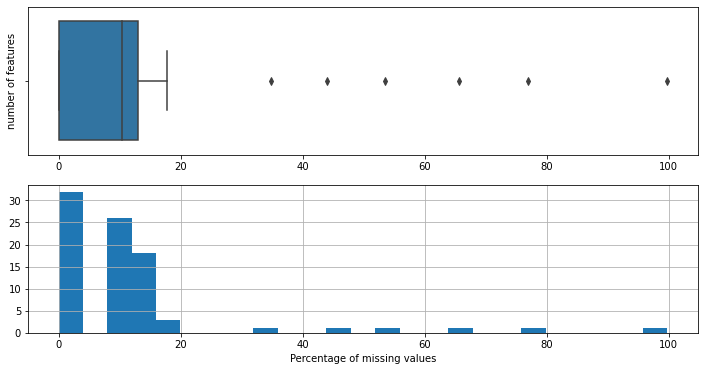

In [16]:
# Histogram that represents the missing values per feature
def plot(df,xl,yl):
    f, axes = plt.subplots(2,1,figsize=(12, 6))
    sns.boxplot(df,ax=axes[0])
    df.hist(bins=25,ax=axes[1])
    axes[0].set_ylabel(yl)
    axes[1].set_xlabel(xl)
    plt.show()

plot(nan_perct,'Percentage of missing values','number of features')

this histogram tell us that there is some features that has many many missing values 
and that the most of the features have less than 20% missing values
so we conclude that those above 20% missing values are outliers and will be removed

In [17]:
#columns with high nan to be romved 
columns_high_nan=nan_perct[nan_perct>20]
columns_high_nan

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

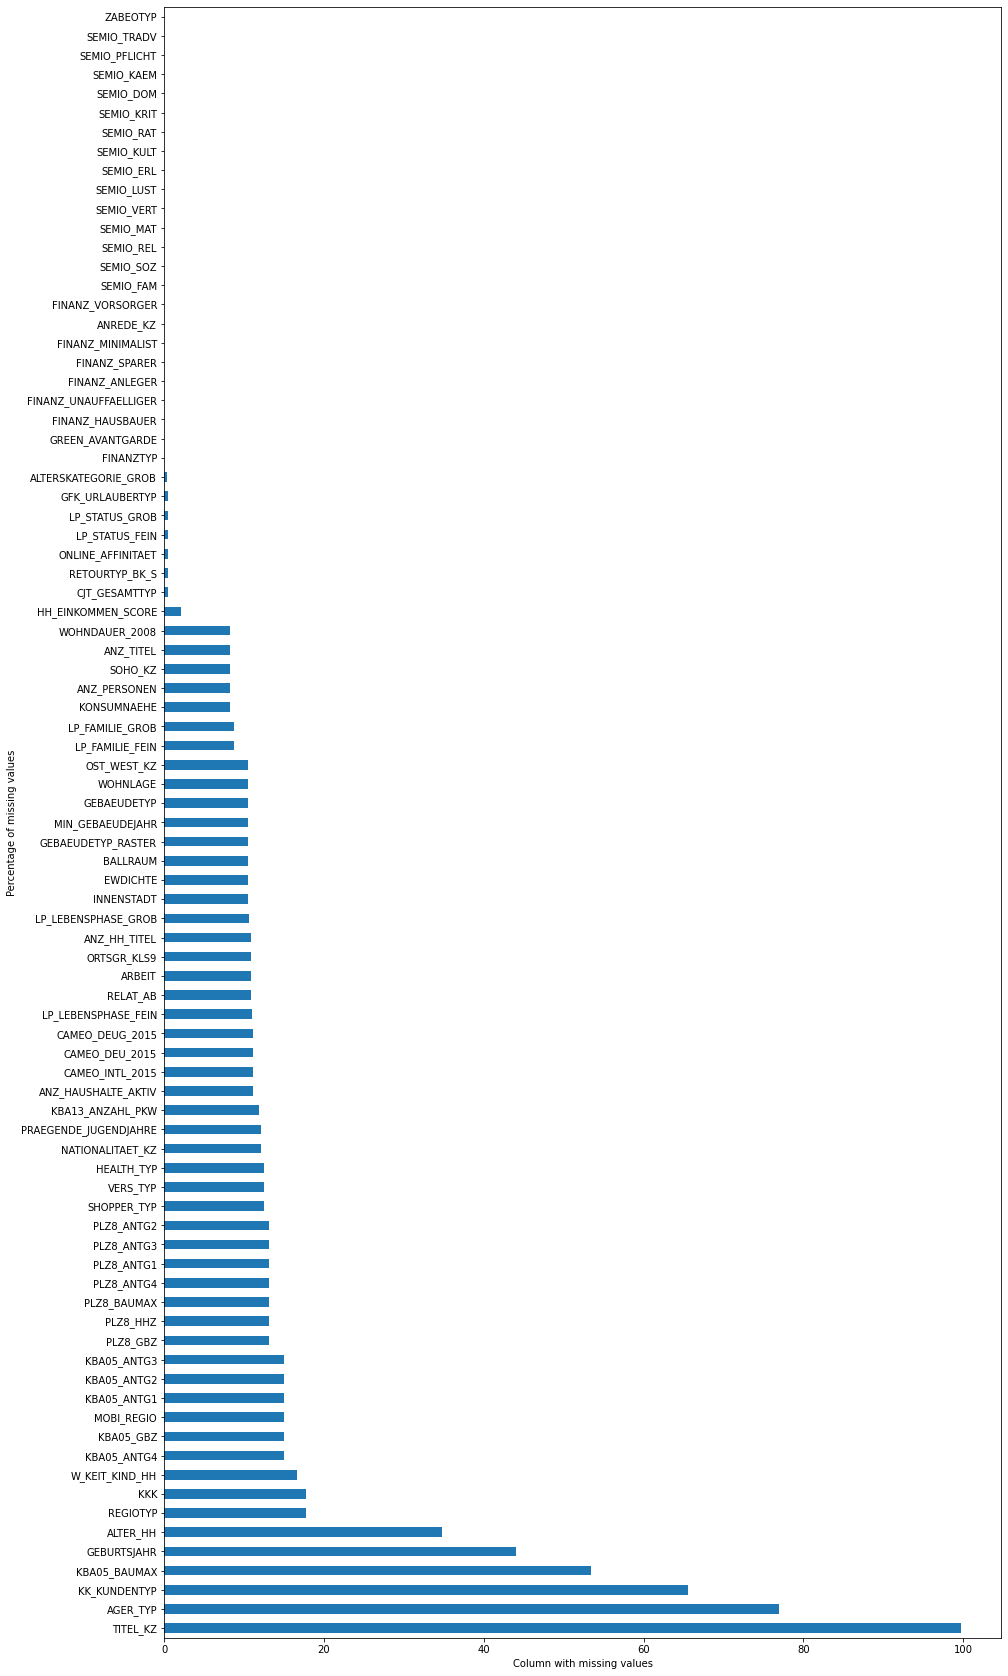

In [18]:
# Investigate patterns in the amount of missing data in each column.
nan_perct.plot.barh(figsize=(15,30))
plt.xlabel('Column with missing values')
plt.ylabel('Percentage of missing values')

plt.show()

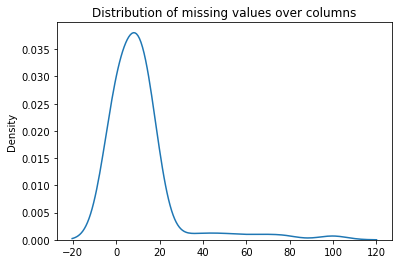

In [19]:
sns.kdeplot(x=nan_perct)
plt.title('Distribution of missing values over columns')
plt.show()

In [20]:
mis_data=pd.DataFrame({'features':nan_perct.index,'nan_percentage':nan_perct}).reset_index(drop=True)
mis_data

,features,nan_percentage
0,TITEL_KZ,99.757636
1,AGER_TYP,76.955435
2,KK_KUNDENTYP,65.596749
3,KBA05_BAUMAX,53.468668
4,GEBURTSJAHR,44.020282
...,...,...
80,SEMIO_DOM,0.000000
81,SEMIO_KAEM,0.000000
82,SEMIO_PFLICHT,0.000000
83,SEMIO_TRADV,0.000000


In [21]:
features_to_drop=mis_data[mis_data['nan_percentage']>20]['features']
features_to_drop

0        TITEL_KZ
1        AGER_TYP
2    KK_KUNDENTYP
3    KBA05_BAUMAX
4     GEBURTSJAHR
5        ALTER_HH
Name: features, dtype: object

In [22]:
data.drop(features_to_drop,axis=1,inplace=True)

### Discussion 1.1.2: Assess Missing Data in Each Column

* Feature that have missing values with percentages above 20% are affecting the data as there is a clear skewing
so they have been removed 
* those are :
    * [TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH]

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?

In [24]:
#amount of missing data in each row 
row_nan_perct=data.isnull().sum(axis=1)*100/len(data.columns)
row_nan_perct

0         54.430380
1          0.000000
2          0.000000
3          8.860759
4          0.000000
            ...    
891216     3.797468
891217     5.063291
891218     6.329114
891219     0.000000
891220     0.000000
Length: 891221, dtype: float64

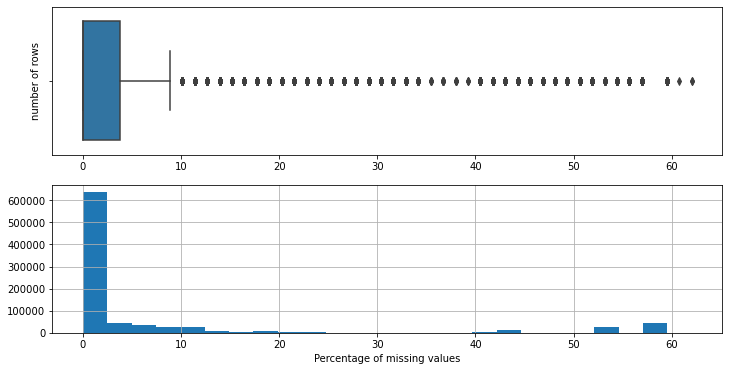

In [25]:
plot(row_nan_perct,'Percentage of missing values','number of rows')

this histogram tell us that there are few rows that has many many missing values 
and that the most of rows have less than 10% missing values
so w will take 10% as our threshold to divide the data into two subsets for comparison

In [26]:
# Write code to divide the data into two subsets based on the number of missingvalues in each row.

In [27]:
threshhold=10

In [28]:
data_above=data[row_nan_perct>=threshhold]
data_above

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1.0,2,5.0,1,4,3,5,5,2,1,...,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,4.0,2,4.0,4,1,5,1,1,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,8.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891175,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891184,3.0,2,6.0,1,5,3,5,4,5,1,...,1.0,4.0,3.0,1.0,3.0,3.0,2.0,4.0,8.0,3.0
891185,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891187,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_below=data[row_nan_perct<threshhold]
data_below

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [30]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.

In [31]:
nan_perct[80:].index

Index(['SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP'], dtype='object')

In [32]:
#choose non-missing features  
selected_columns=nan_perct[80:].index
selected_columns

Index(['SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP'], dtype='object')

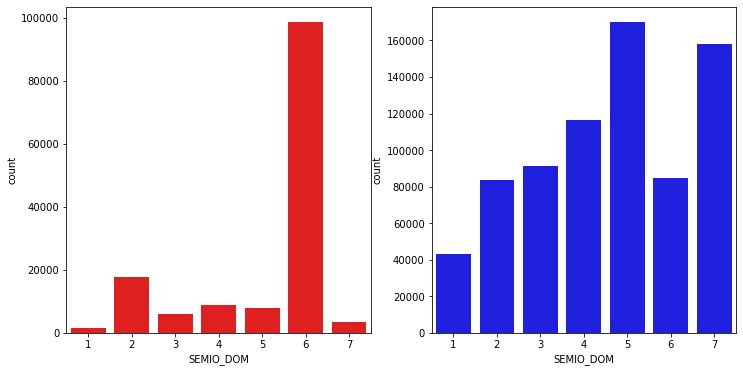

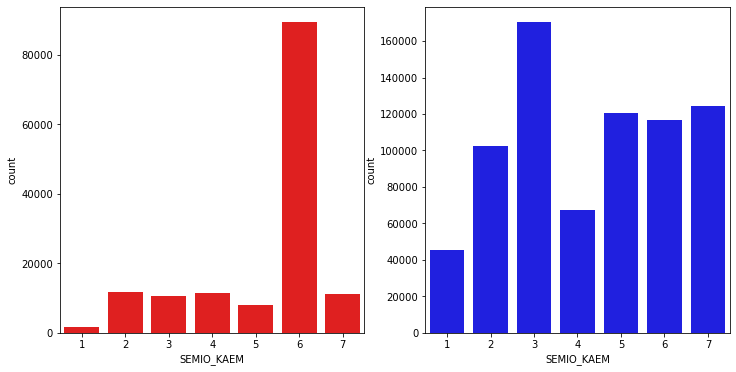

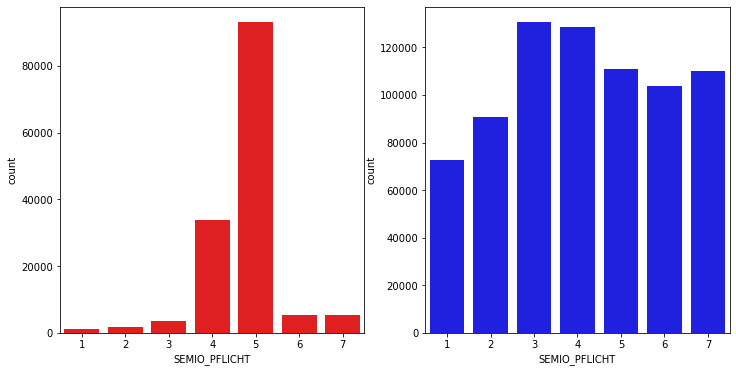

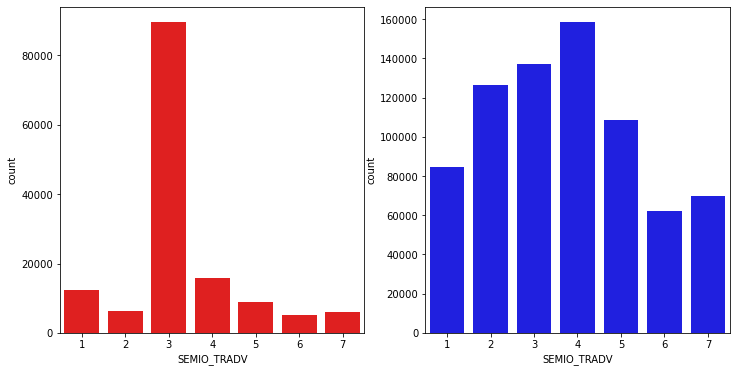

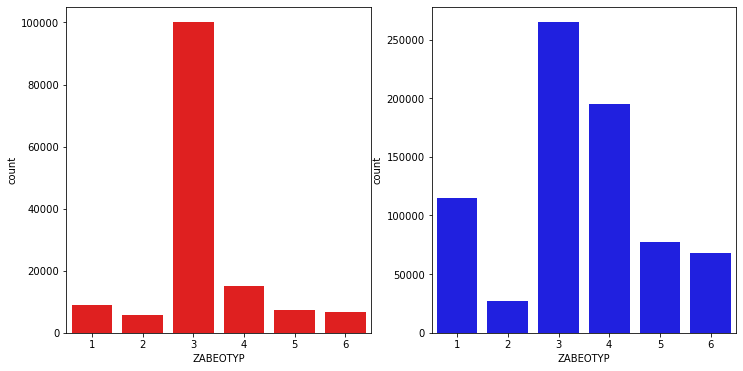

In [33]:
#comaparing distributions 


for col in selected_columns:
    f, axes = plt.subplots(1,2,figsize=(12, 6))
    sns.countplot(data_above[col],ax=axes[0],color='r')
    sns.countplot(data_below[col],ax=axes[1],color='b')


#### Discussion 1.1.3: Assess Missing Data in Each Row

From previous figures we can conclude that 
* the distributions of non-missing features look different between the data with above 10%  missing values and the data with below 10%  missing values
* so we have dropped the data with above 10%  missing values from the analysis as they won't present a major issue

In [34]:
#updating the feat_info dataset ,by droppng  missing_or_unknown column
feat_info=feat_info[feat_info.columns[:-1]]
feat_info

,attribute,information_level,type
0,AGER_TYP,person,categorical
1,ALTERSKATEGORIE_GROB,person,ordinal
2,ANREDE_KZ,person,categorical
3,CJT_GESAMTTYP,person,categorical
4,FINANZ_MINIMALIST,person,ordinal
...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal
81,PLZ8_GBZ,macrocell_plz8,ordinal
82,ARBEIT,community,ordinal
83,ORTSGR_KLS9,community,ordinal


In [35]:
# keeping the data below 10% only
data=data_below
data

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,5.0,1,4,2,5,4,4,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,2.0,1,4.0,3,3,3,2,2,3,6,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,2.0,2,4.0,2,4,2,5,4,3,1,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,1.0,1,3.0,1,5,3,5,5,5,1,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0


In [36]:
#filter feate_info dataset to keep only the remaining columns
feat_info=feat_info[feat_info['attribute'].isin(data.columns)]

In [37]:
feat_info

,attribute,information_level,type
1,ALTERSKATEGORIE_GROB,person,ordinal
2,ANREDE_KZ,person,categorical
3,CJT_GESAMTTYP,person,categorical
4,FINANZ_MINIMALIST,person,ordinal
5,FINANZ_SPARER,person,ordinal
...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal
81,PLZ8_GBZ,macrocell_plz8,ordinal
82,ARBEIT,community,ordinal
83,ORTSGR_KLS9,community,ordinal


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
# How many features are there for each data type?

In [39]:
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [40]:

feat_info['type'].value_counts(normalize=True)

ordinal        0.620253
categorical    0.227848
mixed          0.075949
numeric        0.075949
Name: type, dtype: float64

- mixed+categorical = 24 out of 79 features
- 62% of features are ordinal

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [41]:
cate=feat_info[feat_info['type']=='categorical']
cate

,attribute,information_level,type
2,ANREDE_KZ,person,categorical
3,CJT_GESAMTTYP,person,categorical
10,FINANZTYP,person,categorical
12,GFK_URLAUBERTYP,person,categorical
13,GREEN_AVANTGARDE,person,categorical
17,LP_FAMILIE_FEIN,person,categorical
18,LP_FAMILIE_GROB,person,categorical
19,LP_STATUS_FEIN,person,categorical
20,LP_STATUS_GROB,person,categorical
21,NATIONALITAET_KZ,person,categorical


In [42]:
# Assess categorical variables: which are binary, which are multi-level, and

In [43]:
d={}
for col in cate.attribute:
    if len(data[col].value_counts()) >2:
        d[col]='multi-level'
    else:
        d[col]='binary'
d

{'ANREDE_KZ': 'binary',
 'CJT_GESAMTTYP': 'multi-level',
 'FINANZTYP': 'multi-level',
 'GFK_URLAUBERTYP': 'multi-level',
 'GREEN_AVANTGARDE': 'binary',
 'LP_FAMILIE_FEIN': 'multi-level',
 'LP_FAMILIE_GROB': 'multi-level',
 'LP_STATUS_FEIN': 'multi-level',
 'LP_STATUS_GROB': 'multi-level',
 'NATIONALITAET_KZ': 'multi-level',
 'SHOPPER_TYP': 'multi-level',
 'SOHO_KZ': 'binary',
 'VERS_TYP': 'binary',
 'ZABEOTYP': 'multi-level',
 'GEBAEUDETYP': 'multi-level',
 'OST_WEST_KZ': 'binary',
 'CAMEO_DEUG_2015': 'multi-level',
 'CAMEO_DEU_2015': 'multi-level'}

In [44]:
sorted(d.values())

['binary',
 'binary',
 'binary',
 'binary',
 'binary',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level',
 'multi-level']

In [45]:
data[cate.attribute].dtypes

ANREDE_KZ             int64
CJT_GESAMTTYP       float64
FINANZTYP             int64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE      int64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
ZABEOTYP              int64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

In [46]:
cate.attribute[-3:]

55        OST_WEST_KZ
57    CAMEO_DEUG_2015
58     CAMEO_DEU_2015
Name: attribute, dtype: object

In [47]:
data[cate.attribute[-3:]]

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,W,8,8A
2,W,4,4C
3,W,2,2A
4,W,6,6B
5,W,8,8C
...,...,...,...
891216,W,7,7A
891217,W,9,9D
891218,W,4,4C
891219,W,9,9D


In [48]:
len(data['OST_WEST_KZ'].value_counts())

2

### which one needs to be re-encoded?
'OST_WEST_KZ' feature  


In [49]:
data['OST_WEST_KZ']=pd.get_dummies(data=data['OST_WEST_KZ'],drop_first=True)
data.rename({'1':'OST_WEST_KZ'},inplace=True)

In [50]:
multi_level_features=[]
for col in cate.attribute:
    if len(data[col].value_counts()) >2:
        multi_level_features.append(col)
multi_level_features   

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [51]:
len(data['CAMEO_DEU_2015'].value_counts())


45

* if we try to encode any of multilevel features ,our dataset will get more variables
* which is not acceptable so we will drop these columns directly

In [52]:
data.drop(multi_level_features,axis=1,inplace=True)

In [53]:
data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

* I have kept `OST_WEST_KZ` feature and encoded it
* I have dropped all of the multi-level features that may increase number of features

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [54]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

In [55]:
data[['PRAEGENDE_JUGENDJAHRE']].value_counts()

PRAEGENDE_JUGENDJAHRE
14.0                     172962
8.0                      134174
5.0                       81722
10.0                      80531
3.0                       51786
15.0                      39539
11.0                      33179
9.0                       32497
6.0                       25125
12.0                      23339
4.0                       20068
1.0                       19583
2.0                        7340
13.0                       5301
7.0                        3890
dtype: int64

from data dictionary:
    
PRAEGENDE_JUGENDJAHRE :
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west)

gen:
- 1: 40s
- 2: 50s
- 3: 60s
- 4: 70s
- 5: 80s
- 6: 90s
    
movement:
- 1 mainstream
- 2 avantgarde

In [56]:
df=data.copy()
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [57]:
#gen
gen_d={1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,14: 6, 15: 6}
movement_d={1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2}

df['gen']=df['PRAEGENDE_JUGENDJAHRE'].replace(gen_d)
df['gen']

1         6.0
2         6.0
3         4.0
4         4.0
5         2.0
         ... 
891216    6.0
891217    5.0
891218    6.0
891219    6.0
891220    2.0
Name: gen, Length: 747162, dtype: float64

In [58]:
df['movement']=df['PRAEGENDE_JUGENDJAHRE'].replace(movement_d)
df['movement']


1         1.0
2         2.0
3         1.0
4         1.0
5         1.0
         ... 
891216    1.0
891217    1.0
891218    1.0
891219    1.0
891220    1.0
Name: movement, Length: 747162, dtype: float64

In [59]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

In [60]:
df['CAMEO_INTL_2015'].value_counts()


51    128033
41     87902
24     85759
14     59027
43     54044
54     43637
25     37564
22     30589
45     25124
13     24528
55     22681
23     20328
52     19627
34     17537
15     16296
31     16285
44     14117
12     11980
35      9882
32      9777
33      9161
XX       297
Name: CAMEO_INTL_2015, dtype: int64

<AxesSubplot:>

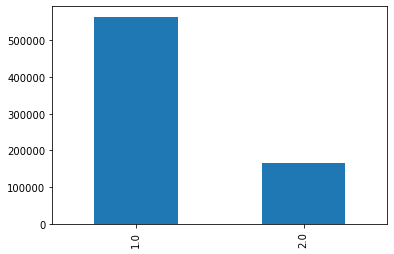

In [61]:
df['movement'].value_counts().plot(kind='bar')
#1 mainstream 
#2 avantgarde

<AxesSubplot:>

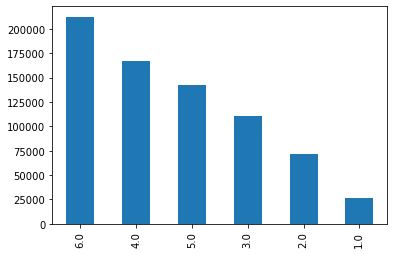

In [62]:
df['gen'].value_counts().plot(kind='bar')
# 1: 40s
# 2: 50s
# 3: 60s
# 4: 70s
# 5: 80s
# 6: 90s

from data dictionary:
    
CAMEO_INTL_2015: German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

#Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables

wealth:
    
1: Wealthy Households
    
2: Prosperous Households
    
3: Comfortable Households
    
4: Less Affluent Households
    
5: Poorer Households

Life Stage :
        
1: Pre-Family Couples & Singles
    
2: Young Couples With Children
    
3: Families With School Age Children
    
4: Older Families & Mature Couples
    
5: Elders In Retirement

In [63]:
def get_wealth(x):
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])
    except:
        return np.nan

def get_lifestage(x):
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
    except:
        return np.nan

df['wealth']=df['CAMEO_INTL_2015'].apply(get_wealth)
df['life_stage']=df['CAMEO_INTL_2015'].apply(get_lifestage)

<AxesSubplot:>

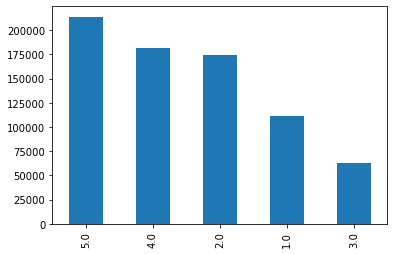

In [64]:
df['wealth'].value_counts().plot(kind='bar')
# 1: Wealthy Households
# 2: Prosperous Households
# 3: Comfortable Households
# 4: Less Affluent Households
# 5: Poorer Households

<AxesSubplot:>

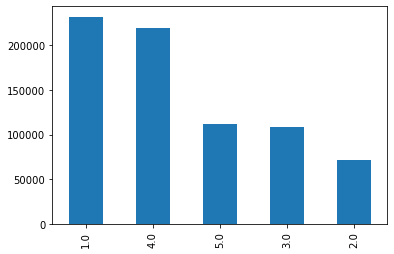

In [65]:
df['life_stage'].value_counts().plot(kind='bar')
# 1: Pre-Family Couples & Singles
# 2: Young Couples With Children
# 3: Families With School Age Children
# 4: Older Families & Mature Couples
# 5: Elders In Retirement

In [66]:
#we have worked on the importnat mixed features we will drop other mixed features

In [67]:
mixed_columns=feat_info[feat_info.type=='mixed']
#nothing here deserve for work on 
mixed_columns

,attribute,information_level,type
15,LP_LEBENSPHASE_FEIN,person,mixed
16,LP_LEBENSPHASE_GROB,person,mixed
22,PRAEGENDE_JUGENDJAHRE,person,mixed
56,WOHNLAGE,building,mixed
59,CAMEO_INTL_2015,microcell_rr4,mixed
79,PLZ8_BAUMAX,macrocell_plz8,mixed


In [68]:
df.drop(mixed_columns.attribute,axis=1,inplace=True)

In [69]:
df

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,gen,movement,wealth,life_stage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,3.0,2,1,4,2,5,4,4,0,3.0,...,0.0,2.0,3.0,NaN,NaN,NaN,6.0,1.0,4.0,1.0
891217,2.0,1,3,3,3,2,2,3,0,NaN,...,2.0,5.0,3.0,4.0,6.0,5.0,5.0,1.0,5.0,1.0
891218,2.0,2,2,4,2,5,4,3,0,1.0,...,0.0,3.0,4.0,2.0,2.0,3.0,6.0,1.0,2.0,4.0
891219,1.0,1,1,5,3,5,5,5,0,1.0,...,1.0,1.0,1.0,4.0,7.0,5.0,6.0,1.0,5.0,1.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

We have done Data engineering on the mixed type features `PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015`
and got new features  from them , after that we have dropped all mixed features as nothing deserve to work on 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [70]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [71]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
final_data=df.reset_index(drop=True)
final_data

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,gen,movement,wealth,life_stage
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747157,3.0,2,1,4,2,5,4,4,0,3.0,...,0.0,2.0,3.0,NaN,NaN,NaN,6.0,1.0,4.0,1.0
747158,2.0,1,3,3,3,2,2,3,0,NaN,...,2.0,5.0,3.0,4.0,6.0,5.0,5.0,1.0,5.0,1.0
747159,2.0,2,2,4,2,5,4,3,0,1.0,...,0.0,3.0,4.0,2.0,2.0,3.0,6.0,1.0,2.0,4.0
747160,1.0,1,1,5,3,5,5,5,0,1.0,...,1.0,1.0,1.0,4.0,7.0,5.0,6.0,1.0,5.0,1.0


In [72]:
# Checking if all columns are numerical
from pandas.api.types import is_numeric_dtype

assert(sum([is_numeric_dtype(final_data[col]) for col in final_data.columns]) == final_data.shape[1])
print('Tests OK')

Tests OK


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [73]:
def clean_data(data):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')
    
        #convert missing/unknown to nan
    for idx,col in enumerate(data.columns):
        try:
            l=list(map(int,feat_info['missing_or_unknown'][idx].strip('][').split(',')))
            data[col].replace(to_replace=l,value=np.nan,inplace=True)
        except:
            continue
    
        #perecentage of missing values in each column
    nan_perct=(data.isnull().sum()*100/len(data)).sort_values(ascending=False)

    mis_data=pd.DataFrame({'features':nan_perct.index,'nan_percentage':nan_perct}).reset_index(drop=True)
    
    #it wil be 
    #20 threshhold for population dataset 
    #35 threshhold for customers dataset
    thresh=35
    features_to_drop=mis_data[mis_data['nan_percentage']>thresh]['features']

    data.drop(features_to_drop,axis=1,inplace=True)
    
    #amount of missing data in each row 
    row_nan_perct=data.isnull().sum(axis=1)*100/len(data.columns)
    
    
    threshhold=10

    data_above=data[row_nan_perct>=threshhold]
    data_below=data[row_nan_perct<threshhold]

    
    selected_columns=nan_perct[80:].index

    
    #updating the feat_info dataset ,by droppng  missing_or_unknown column
    feat_info=feat_info[feat_info.columns[:-1]]
    
    
    
    # keeping the data below 10% only
    data=data_below
    
    
    
    #filter feate_info dataset to keep only the remaining columns
    feat_info=feat_info[feat_info['attribute'].isin(data.columns)]
    
    
    cate=feat_info[feat_info['type']=='categorical']

    
    
    d={}
    for col in cate.attribute:
        if len(data[col].value_counts()) >2:
            d[col]='multi-level'
        else:
            d[col]='binary'
    
    
    data['OST_WEST_KZ']=pd.get_dummies(data=data['OST_WEST_KZ'],drop_first=True)
    data.rename({'1':'OST_WEST_KZ'},inplace=True)
    
    
    
    multi_level_features=[]
    for col in cate.attribute:
        if len(data[col].value_counts()) >2:
            multi_level_features.append(col)
    
    
    data.drop(multi_level_features,axis=1,inplace=True)
    
    
    df=data.copy()

    
        #gen
    gen_d={1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,14: 6, 15: 6}
    movement_d={1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2}

    df['gen']=df['PRAEGENDE_JUGENDJAHRE'].replace(gen_d)
    df['gen']

    df['movement']=df['PRAEGENDE_JUGENDJAHRE'].replace(movement_d)

    def get_wealth(x):
        try:
            if pd.isnull(x):
                return np.nan
            else:
                return int(str(x)[0])
        except:
            return np.nan

    def get_lifestage(x):
        try:
            if pd.isnull(x):
                return np.nan
            else:
                return int(str(x)[1])
        except:
            return np.nan

    df['wealth']=df['CAMEO_INTL_2015'].apply(get_wealth)
    df['life_stage']=df['CAMEO_INTL_2015'].apply(get_lifestage)
    
    
    mixed_columns=feat_info[feat_info.type=='mixed']

    df.drop(mixed_columns.attribute,axis=1,inplace=True)
    
    final_data=df.reset_index(drop=True)

    from pandas.api.types import is_numeric_dtype

    assert(sum([is_numeric_dtype(final_data[col]) for col in final_data.columns]) == final_data.shape[1])
    print('Tests OK')
    
    return final_data
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

This can be as simple as just removing all data points with missing data, or applying an Imputer to replace all missing values

how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.

In [74]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [75]:
#percentage of nan values per feature
(final_data.isnull().sum()*100/len(final_data)).sort_values(ascending=False)

W_KEIT_KIND_HH        6.082349
KKK                   5.410072
REGIOTYP              5.410072
HEALTH_TYP            3.260872
VERS_TYP              3.260872
                        ...   
ONLINE_AFFINITAET     0.000000
ANZ_PERSONEN          0.000000
ANZ_TITEL             0.000000
HH_EINKOMMEN_SCORE    0.000000
WOHNDAUER_2008        0.000000
Length: 64, dtype: float64

In [76]:
#percentage of nan values per row
nan_rows=(final_data.isnull().sum(axis=1)*100/len(final_data)).sort_values(ascending=False)

In [77]:
#pecentage of rows that have nan values 
len(nan_rows[nan_rows>0])/len(final_data)*100

16.589574951616918

In [78]:
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [79]:
#ordinal .mixed/median
#categorical  / mode
#numric / mean

In [80]:
feat=feat_info[feat_info['attribute'].isin(final_data.columns)]
feat.type.value_counts()

ordinal        49
numeric         6
categorical     5
Name: type, dtype: int64

In [81]:
len(feat.attribute)

60

In [82]:
fd=final_data.copy()

In [83]:
len(fd.columns)

64

In [84]:
fd.isnull().sum().sum()

321067

In [85]:
for col,ty in zip(feat.attribute,feat.type):
    if ty =='numeric':
        fd[col].fillna(fd[col].mean(),inplace=True)
    elif ty =='ordinal':
        fd[col].fillna(fd[col].median(),inplace=True)
    elif ty =='categorical':
        fd[col].fillna(fd[col].mode(),inplace=True)

In [86]:
nan_perct=fd.isnull().sum()*100/len(fd)
fd_data=pd.DataFrame({'features':nan_perct.index,'nan_percentage':nan_perct}).reset_index(drop=True)
fd_data[fd_data['nan_percentage']>0]['features']

26      VERS_TYP
60           gen
61      movement
62        wealth
63    life_stage
Name: features, dtype: object

In [87]:
fd['gen'].fillna(fd['gen'].median(),inplace=True)

In [88]:
fd['movement'].fillna(fd['movement'].median(),inplace=True)

In [89]:
fd['wealth'].fillna(fd['wealth'].median(),inplace=True)

In [90]:
fd['life_stage'].fillna(fd['life_stage'].median(),inplace=True)

In [91]:
fd['VERS_TYP'].fillna(fd['VERS_TYP'].median(),inplace=True)

In [92]:
fd.isnull().sum().sum()

0

## Data Cleaning is Finished

In [93]:
# Apply feature scaling to the general population demographics data.

In [94]:
from sklearn.preprocessing import StandardScaler

scalar=StandardScaler()
scalar.fit(fd)

StandardScaler()

In [95]:
X_scale=scalar.transform(fd)

In [96]:
df_scale = pd.DataFrame(X_scale, columns=fd.columns)
df_scale

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,gen,movement,wealth,life_stage
0,-1.754936,0.962853,-1.503710,1.559956,-1.049506,1.490726,1.013135,1.331199,-0.536391,1.073635,...,0.406003,1.432374,0.566184,-0.180139,-0.136808,0.676630,1.168847,-0.536391,1.170379,-1.259778
1,0.198232,0.962853,-1.503710,0.884847,-1.773049,-0.555621,0.291114,1.331199,1.864312,1.073635,...,-0.969566,0.401787,0.566184,-0.180139,-0.136808,-0.800153,1.168847,1.864312,-0.879465,0.755646
2,1.174816,0.962853,0.685627,-0.465371,1.121124,-0.555621,-1.152927,-0.831789,-0.536391,-0.270691,...,-0.969566,-0.628801,0.566184,-1.187089,-1.008378,-0.061761,-0.214971,-0.536391,-1.562746,-0.587970
3,0.198232,-1.038580,0.685627,0.209738,0.397581,-1.237737,0.291114,-0.831789,-0.536391,1.073635,...,0.406003,-0.628801,-0.335113,0.826811,0.298977,1.415021,-0.214971,-0.536391,0.487098,0.083838
4,-1.754936,0.962853,-0.044152,-1.140480,1.121124,-0.555621,-0.430907,1.331199,-0.536391,1.073635,...,0.406003,1.432374,1.467481,-1.187089,-1.008378,-0.061761,-1.598789,-0.536391,1.170379,0.755646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747157,0.198232,0.962853,-1.503710,0.884847,-1.049506,1.490726,1.013135,0.610203,-0.536391,1.073635,...,-0.969566,-1.659388,-0.335113,-0.180139,-0.136808,-0.061761,1.168847,-0.536391,0.487098,-1.259778
747158,-0.778352,-1.038580,-0.044152,0.209738,-0.325963,-0.555621,-0.430907,-0.110793,-0.536391,-0.270691,...,1.781573,1.432374,-0.335113,0.826811,0.298977,1.415021,0.476938,-0.536391,1.170379,-1.259778
747159,-0.778352,0.962853,-0.773931,0.884847,-1.049506,1.490726,1.013135,-0.110793,-0.536391,-1.615017,...,-0.969566,-0.628801,0.566184,-1.187089,-1.444163,-0.061761,1.168847,-0.536391,-0.879465,0.755646
747160,-1.754936,-1.038580,-1.503710,1.559956,-0.325963,1.490726,1.735156,1.331199,-0.536391,-1.615017,...,0.406003,-2.689976,-2.137708,0.826811,0.734762,1.415021,1.168847,-0.536391,1.170379,-1.259778


*********

*******

### Discussion 2.1: Apply Feature Scaling

* Percentage of rows that have NaN values represents about 16.5 % of all the rows 
* I think it will be a loss if we dropped them so we have handled them by replacing the missing values with the appropriate values


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [97]:
# Investigate the variance accounted for by each principal component.
def plot_pca(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals=np.cumsum(vals)
    plt.figure(figsize=(15,7))
    ax=plt.subplot(111)
    ax.bar(ind,vals)
    ax.plot(ind,cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)


    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.show()

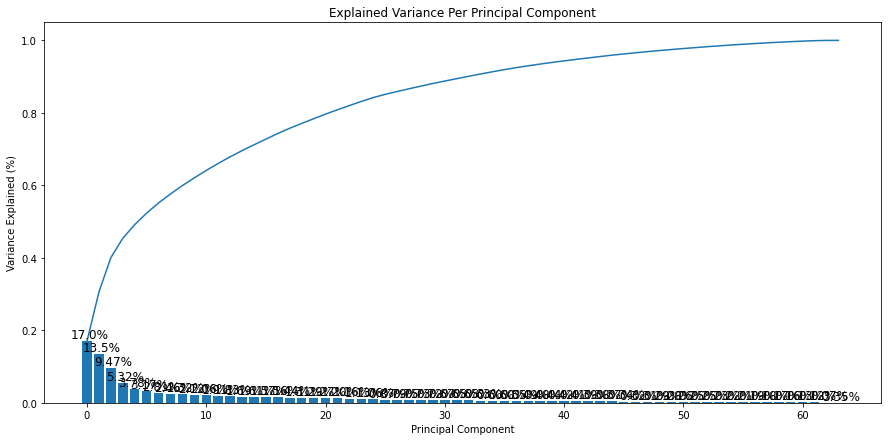

In [98]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca=PCA()
x_pca=pca.fit_transform(df_scale)

plot_pca(pca)

In [99]:
# Re-apply PCA to the data while selecting for number of components to retain.
#select a value for the number of transformed features you'll retain for the clustering part of the project.
#com=15
for com in range(2,30):
    pca=PCA(n_components=com)
    x_pca=pca.fit_transform(df_scale)
    print(f'cumulative variance for {com} components = {np.sum(pca.explained_variance_ratio_)}')
    #plot_pca(pca)

cumulative variance for 2 components = 0.3058476918344307
cumulative variance for 3 components = 0.4005886093314478
cumulative variance for 4 components = 0.45387542849850143
cumulative variance for 5 components = 0.49170271690564726
cumulative variance for 6 components = 0.5234590119080986
cumulative variance for 7 components = 0.5515439239804834
cumulative variance for 8 components = 0.5762199347777767
cumulative variance for 9 components = 0.5992143588086676
cumulative variance for 10 components = 0.6206055286008624
cumulative variance for 11 components = 0.6411349259985462
cumulative variance for 12 components = 0.6603057558551878
cumulative variance for 13 components = 0.6784064041963731
cumulative variance for 14 components = 0.6956411086696368
cumulative variance for 15 components = 0.7118391312178161
cumulative variance for 16 components = 0.7274509038191288
cumulative variance for 17 components = 0.7431663703881098
cumulative variance for 18 components = 0.757552874228657
cumu

In [100]:
#we will choose 25 components 
pca=PCA(25)
x_pca=pca.fit_transform(df_scale)

In [101]:
df_pca = pd.DataFrame(x_pca)
df_pca

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.946944,-2.569659,-2.921814,-0.443041,-2.508417,2.315127,0.815017,1.149156,-0.729208,-0.141345,...,-3.124960,10.377640,-0.179538,0.270646,0.348031,-1.264678,-0.792868,0.160165,-1.070415,-0.744163
1,-0.960361,0.169720,-3.081249,2.298331,-0.859351,-0.140200,-0.984498,0.789684,-1.255230,-0.297133,...,0.914007,0.092240,-1.498199,0.223235,0.827242,2.013585,0.710879,-0.690093,-1.199803,-0.141227
2,-3.936741,1.136726,-0.802425,-0.925457,0.417824,0.110038,0.020843,-0.587005,0.101658,-0.227133,...,0.521018,0.162158,-0.189828,0.200163,-0.821505,-0.168448,-0.821191,1.936792,-1.234124,-0.677937
3,0.557731,0.199975,3.245017,0.551647,1.549031,-2.839925,1.977183,1.172747,-0.836285,1.149043,...,0.670239,-0.062768,-0.264419,-0.523974,-0.287201,-0.280227,1.154444,0.195391,-0.804281,0.232907
4,-0.687837,-1.438337,-1.093248,-1.926893,-3.154698,-0.966550,-0.503294,-3.086120,1.116645,-1.020447,...,-1.837660,-0.515955,1.578044,-1.041778,0.066327,-0.532855,0.242925,0.768051,-1.037521,-0.215004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747157,-0.842860,-1.471058,-3.900391,-1.559807,1.699689,0.257780,0.237231,0.497951,-1.918931,0.582546,...,1.073623,0.125604,1.027900,1.366583,1.282949,0.692049,-0.233576,0.392935,-0.854341,0.697583
747158,4.132441,1.660908,1.301144,-0.368342,-0.878070,-0.251131,1.229860,-0.576711,0.732028,-0.035448,...,-0.202779,-0.078333,-0.475028,0.143743,-0.525588,-0.957830,-0.275262,-0.771216,1.781840,0.343536
747159,-0.837076,-3.395145,-2.993750,-2.219546,-0.826330,-0.074018,-1.596935,-1.050124,0.156284,0.645057,...,1.239241,0.210587,0.421356,-0.268622,0.434462,0.175135,-0.432130,-0.710236,-0.452340,1.726679
747160,5.944958,-3.241172,2.281734,-1.146332,2.566374,-2.539649,-0.447328,0.295441,-0.105935,2.489093,...,-0.277213,-0.218465,-0.681009,-0.955443,-0.024270,-0.873459,0.063547,0.621628,0.064960,1.451470


### Discussion 2.2: Perform Dimensionality Reduction

from the above plot we find that we can choose 25 components which have about 84% of the the variance ratio explained

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

each principal component is a unit vector that points in the direction of highest variance

In [102]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [103]:
weights=pd.DataFrame(np.round(pca.components_, 6), columns=fd.keys())
weights

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,gen,movement,wealth,life_stage
0,-0.123440,0.004567,-0.219502,0.147611,-0.116381,0.069135,0.077395,0.159073,-0.111216,0.029213,...,0.218138,0.041076,-0.167099,0.142675,0.195181,0.133668,0.105088,-0.111216,0.205649,-0.125165
1,0.257150,0.089594,0.063759,-0.233953,0.229856,-0.204755,-0.225135,0.118218,-0.017759,-0.058189,...,0.092237,0.013807,-0.074037,0.068501,0.092521,0.065864,-0.248851,-0.017759,0.075772,-0.000824
2,0.079812,-0.369310,0.156762,-0.103828,0.099436,-0.188024,-0.095996,-0.045428,0.048901,-0.015216,...,0.045036,0.005105,-0.037390,0.033247,0.046484,0.030917,-0.106944,0.048901,0.025730,-0.008668
3,-0.042640,0.038087,0.063437,-0.001970,-0.017304,-0.126642,0.085797,-0.106581,0.397824,0.004016,...,0.082967,0.138291,0.033463,0.050526,0.248733,0.094334,0.039165,0.397824,-0.124767,0.059050
4,0.002178,0.006626,0.085964,-0.004552,-0.061290,0.040572,-0.046429,-0.087840,0.060041,0.015728,...,0.017335,-0.492078,-0.403954,0.218105,0.093529,0.148563,0.028728,0.060041,-0.008383,0.025171
5,-0.003952,0.017993,-0.030557,0.004994,-0.032494,0.021654,-0.029894,0.039057,0.011110,-0.030021,...,0.086908,-0.034643,-0.084095,-0.171986,-0.074761,-0.209724,0.011385,0.011110,-0.071320,0.057559
6,0.033541,-0.058521,0.052441,0.060121,-0.017449,0.078246,0.047427,-0.190575,-0.021840,0.210966,...,0.052142,0.213081,0.122477,0.007059,0.113796,0.022906,0.099680,-0.021840,0.016972,-0.076094
7,0.150911,-0.023655,-0.086578,0.118090,-0.157033,0.155306,0.053555,0.035750,0.049910,-0.087121,...,0.094563,0.077483,-0.017690,0.036803,-0.108534,-0.020610,0.135404,0.049910,0.069350,-0.030722
8,-0.004511,0.093975,0.057817,-0.116443,0.067792,-0.015948,-0.142110,0.065821,0.006240,-0.423068,...,0.052971,0.187669,0.098096,0.184870,0.050997,0.075007,-0.130423,0.006240,0.022359,0.049972
9,0.058536,0.023373,-0.026442,0.004934,0.108441,-0.063807,0.102562,-0.041836,-0.021355,-0.213925,...,-0.034870,-0.231735,-0.151374,-0.408706,-0.059458,-0.167926,-0.003262,-0.021355,0.060656,-0.183880


In [104]:
pca.components_.shape

(25, 64)

In [105]:
component=weights.iloc[0]
component

ALTERSKATEGORIE_GROB   -0.123440
ANREDE_KZ               0.004567
FINANZ_MINIMALIST      -0.219502
FINANZ_SPARER           0.147611
FINANZ_VORSORGER       -0.116381
                          ...   
RELAT_AB                0.133668
gen                     0.105088
movement               -0.111216
wealth                  0.205649
life_stage             -0.125165
Name: 0, Length: 64, dtype: float64

In [106]:
def  map_weights_features(pca,df,n):
    weights=pd.DataFrame(np.round(pca.components_, 6), columns=fd.keys())
    component=weights.iloc[n-1]
    return component.sort_values(ascending=False)

In [107]:
def plot_component(component,n):
    component= pd.concat([component.head(5),component.tail(5)])
    component.plot(kind='bar')
    plt.title(f'component{n}')
    plt.show()

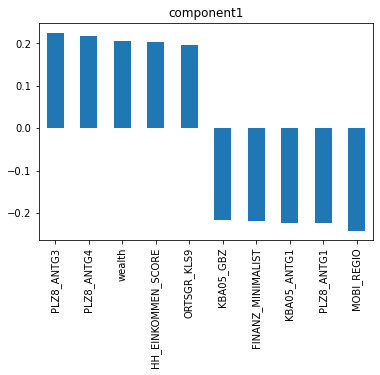

PLZ8_ANTG3            0.224981
PLZ8_ANTG4            0.218138
wealth                0.205649
HH_EINKOMMEN_SCORE    0.202642
ORTSGR_KLS9           0.195181
                        ...   
KBA05_GBZ            -0.216360
FINANZ_MINIMALIST    -0.219502
KBA05_ANTG1          -0.224166
PLZ8_ANTG1           -0.225070
MOBI_REGIO           -0.241704
Name: 0, Length: 64, dtype: float64


In [108]:
comp=1
component=map_weights_features(pca,fd,comp)
plot_component(component,comp)
print(component)

The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign


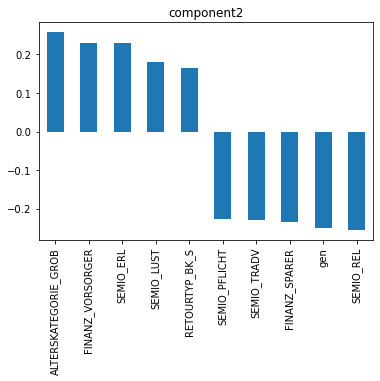

ALTERSKATEGORIE_GROB    0.257150
FINANZ_VORSORGER        0.229856
SEMIO_ERL               0.229227
SEMIO_LUST              0.180917
RETOURTYP_BK_S          0.165647
                          ...   
SEMIO_PFLICHT          -0.227797
SEMIO_TRADV            -0.229322
FINANZ_SPARER          -0.233953
gen                    -0.248851
SEMIO_REL              -0.255129
Name: 1, Length: 64, dtype: float64


In [109]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp=2
component=map_weights_features(pca,fd,comp)
plot_component(component,comp)
print(component)

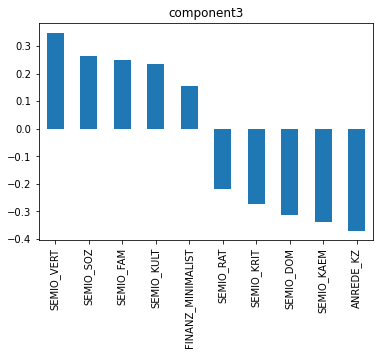

SEMIO_VERT           0.347806
SEMIO_SOZ            0.263937
SEMIO_FAM            0.251126
SEMIO_KULT           0.233203
FINANZ_MINIMALIST    0.156762
                       ...   
SEMIO_RAT           -0.217293
SEMIO_KRIT          -0.271663
SEMIO_DOM           -0.313632
SEMIO_KAEM          -0.337949
ANREDE_KZ           -0.369310
Name: 2, Length: 64, dtype: float64


In [110]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp=3
component=map_weights_features(pca,fd,comp)
plot_component(component,comp)
print(component)

### Discussion 2.3: Interpret Principal Components

From the above plots it seems that each of our three components has a special focus on some features 
based on positive and negative associations with them

This can help us in detecting kind of customers groups 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [111]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...    
# compute the average within-cluster distances.

In [112]:
data=df_pca.copy()
data.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3.946944,-2.569659,-2.921814,-0.443041,-2.508417,2.315127,0.815017,1.149156,-0.729208,-0.141345,...,-3.124960,10.377640,-0.179538,0.270646,0.348031,-1.264678,-0.792868,0.160165,-1.070415,-0.744163
1,-0.960361,0.169720,-3.081249,2.298331,-0.859351,-0.140200,-0.984498,0.789684,-1.255230,-0.297133,...,0.914007,0.092240,-1.498199,0.223235,0.827242,2.013585,0.710879,-0.690093,-1.199803,-0.141227
2,-3.936741,1.136726,-0.802425,-0.925457,0.417824,0.110038,0.020843,-0.587005,0.101658,-0.227133,...,0.521018,0.162158,-0.189828,0.200163,-0.821505,-0.168448,-0.821191,1.936792,-1.234124,-0.677937
3,0.557731,0.199975,3.245017,0.551647,1.549031,-2.839925,1.977183,1.172747,-0.836285,1.149043,...,0.670239,-0.062768,-0.264419,-0.523974,-0.287201,-0.280227,1.154444,0.195391,-0.804281,0.232907
4,-0.687837,-1.438337,-1.093248,-1.926893,-3.154698,-0.966550,-0.503294,-3.086120,1.116645,-1.020447,...,-1.837660,-0.515955,1.578044,-1.041778,0.066327,-0.532855,0.242925,0.768051,-1.037521,-0.215004


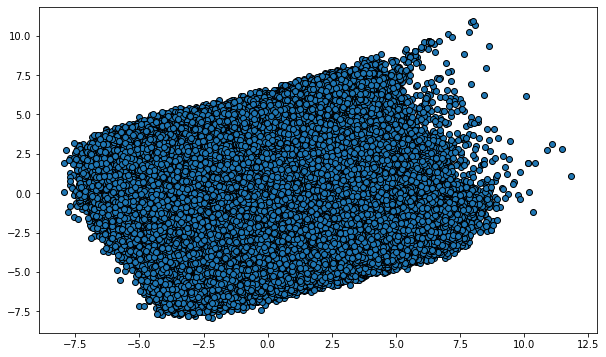

In [113]:
plt.figure(figsize=(10,6))
plt.scatter(data[0],data[1],edgecolors='black')
plt.show()

In [119]:
#applying elbow method to find optimal number of K clusters
#and validation with silhouette score 
from sklearn.cluster import KMeans
import time
start=time.time()
sc = []
for i in range(2, 31):
    kmeans = KMeans(n_clusters = i, max_iter = 300, random_state = 0)
    pred=kmeans.fit_predict(data)
    sc.append(np.abs(kmeans.score(data)))
end=time.time()
t=np.round((end-start)/60,2)

In [120]:
print(f"time Elapsed={t} minutes")

time Elapsed=38.1 minutes


In [121]:
from pygame import mixer  # Load the popular external library

mixer.init()
mixer.music.load('F:\mohamed\Music\Dory.mp3')
mixer.music.play()

pygame 2.1.2 (SDL 2.0.18, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [122]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

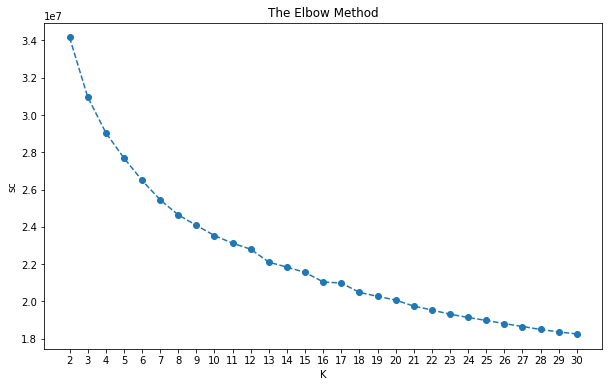

In [123]:
plt.figure(figsize=(10,6))
plt.plot(list(range(2, 31)), sc,linestyle='--',marker='o')
plt.title('The Elbow Method')
plt.xlabel('K')
plt.ylabel('sc')
plt.xticks( range(2, 31))
plt.show()

In [124]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

In [130]:
from sklearn.cluster import KMeans
k=12
kmeans = KMeans(n_clusters = k, max_iter = 300, random_state = 0)

In [131]:
pred=kmeans.fit_predict(data)

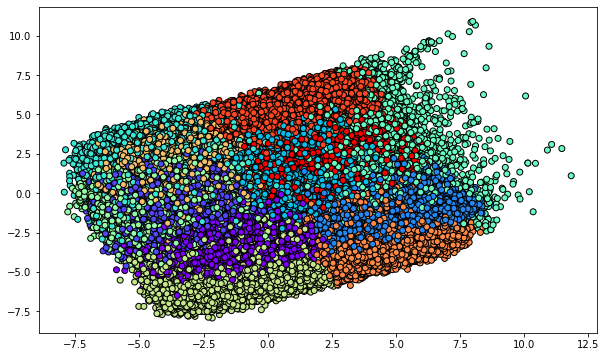

In [132]:
plt.figure(figsize=(10,6))
plt.scatter(data[0],data[1],edgecolors='black',c=pred,cmap='rainbow')
plt.show()

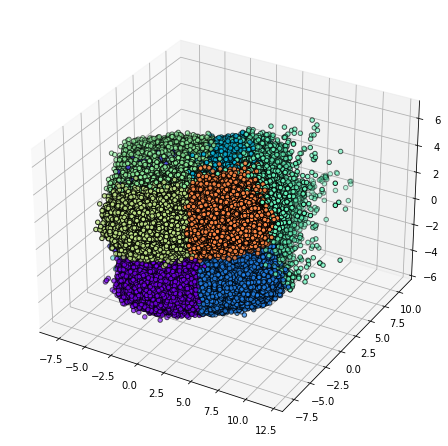

In [133]:
from mpl_toolkits.mplot3d import Axes3D
def plot_data(data, labels):
    
    fig = plt.figure(figsize=(12,6));
    ax = Axes3D(fig)
    ax.scatter(data[0], data[1], data[2], c=labels, edgecolors='black',cmap='rainbow');    

plot_data(data, pred)

### Discussion 3.1: Apply Clustering to General Population

I find 12 clusters pretty good for the Kmeans model

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [135]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

In [179]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [180]:
#clean 1
cust=clean_data(customers)

Tests OK


In [181]:
#clean 2
for col,ty in zip(feat.attribute,feat.type):
    if ty =='numeric':
        cust[col].fillna(cust[col].mean(),inplace=True)
    elif ty =='ordinal':
        cust[col].fillna(cust[col].median(),inplace=True)
    elif ty =='categorical':
        cust[col].fillna(cust[col].mode(),inplace=True)
        
        
cust['gen'].fillna(cust['gen'].median(),inplace=True)

cust['movement'].fillna(cust['movement'].median(),inplace=True)

cust['wealth'].fillna(cust['wealth'].median(),inplace=True)

cust['life_stage'].fillna(cust['life_stage'].median(),inplace=True)

cust['VERS_TYP'].fillna(cust['VERS_TYP'].median(),inplace=True)
        
print(cust.isnull().sum().sum())

0


In [182]:
# Scale
cust_sc = scalar.transform(cust)

In [183]:
cust_pca = pca.transform(cust_sc)
cust_pca.shape

(133477, 25)

In [184]:
df_cust_pca = pd.DataFrame(cust_pca, columns=np.arange(1, 26))
df_cust_pca

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,-5.873924,0.673758,4.251645,2.161125,-3.104622,0.826016,-1.670127,0.849954,0.539870,0.912462,...,0.034341,-0.087485,-0.309476,0.092356,0.329932,0.150554,1.401439,0.242262,-0.151347,0.157325
1,-1.706976,4.823522,-0.656817,2.197473,0.946398,-0.873372,-0.144455,-0.891842,-0.858189,0.762183,...,-1.413306,-0.317653,0.067505,-1.224786,-0.649951,0.335382,-0.344213,-1.245562,0.444451,0.438706
2,-4.356273,0.207432,2.703019,-2.436326,-1.033618,0.969359,-0.699942,-1.378539,0.293202,0.887747,...,-0.528584,-0.163577,0.872231,0.712140,-1.052383,0.926310,-0.850760,0.258070,-0.271029,-0.691030
3,1.504301,-0.895232,1.159231,-0.643953,0.096946,-1.750272,1.466315,0.995343,-0.263086,3.199275,...,-0.911500,-0.384266,-0.039586,-0.616149,0.796764,0.511512,0.234707,-1.119563,1.193100,-0.110622
4,-2.421797,1.200373,2.876564,2.811201,-2.101820,-1.125622,0.426473,0.391147,-0.632179,-1.569351,...,-0.329515,-0.126815,1.241420,-0.787185,-0.301917,0.102391,-0.909380,-0.166430,0.096944,-1.377962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133472,2.825033,1.167910,-1.571045,0.681946,2.506131,-2.343726,-2.214739,-4.352198,-0.349812,1.270839,...,-0.904166,-0.280466,0.126318,-2.131522,-0.426768,-0.586446,-0.842464,-0.139636,-0.892431,0.112909
133473,-1.634964,1.216102,3.177509,5.124390,-0.810631,-1.007671,-1.091021,-1.723966,-0.221912,-1.375148,...,0.501311,0.068631,0.161474,-0.348191,-0.929788,-0.176429,1.557145,-0.409063,0.398984,-1.120867
133474,-4.515083,2.502487,2.402914,1.938991,-0.114752,-0.793398,1.519311,1.075001,1.150604,-0.414325,...,0.332155,-0.069758,0.525499,0.481893,-0.334436,0.713351,-1.216306,0.274617,-0.994552,0.312844
133475,-1.087416,2.682303,-2.017356,-0.289973,1.531221,0.108487,-0.230732,-1.050604,0.686442,1.858697,...,-0.895246,-0.395510,-0.182703,-0.001144,-0.034769,-0.054053,-1.770354,-0.596325,-0.111401,0.231865


In [185]:
cust_pred = kmeans.predict(df_cust_pca)

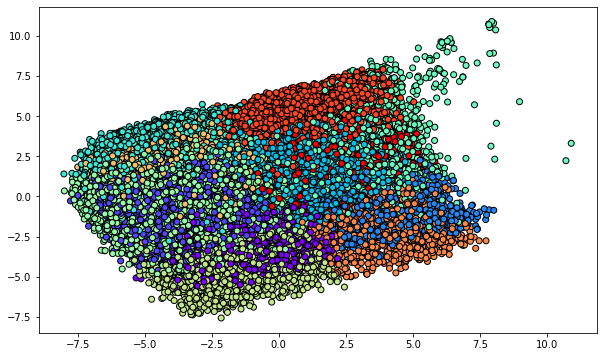

In [186]:
plt.figure(figsize=(10,6))
plt.scatter(cust_pca[:,0],cust_pca[:,1],edgecolors='black',c=cust_pred,cmap='rainbow')
plt.show()

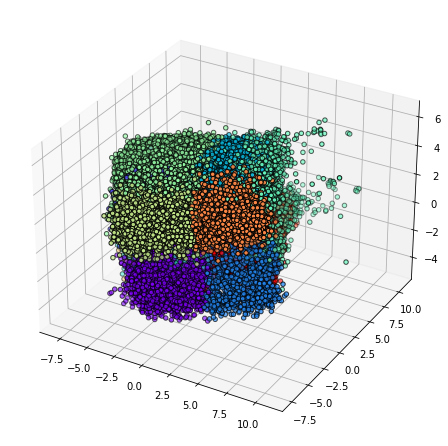

In [187]:
from mpl_toolkits.mplot3d import Axes3D
def plot_data(data, labels):
    
    fig = plt.figure(figsize=(12,6));
    ax = Axes3D(fig)
    ax.scatter(cust_pca[:,0], cust_pca[:,1], cust_pca[:,2], c=labels, edgecolors='black',cmap='rainbow');    

plot_data(cust_pca, cust_pred)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.
m
Take a look at the  following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [188]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
from scipy.stats import itemfreq

In [189]:
#making general population proportions
pred

array([2, 4, 8, ..., 0, 9, 3])

In [190]:
itemfreq(pred)

array([[    0, 73610],
       [    1, 77533],
       [    2, 67614],
       [    3, 76657],
       [    4, 54287],
       [    5, 37305],
       [    6, 56460],
       [    7, 57275],
       [    8, 73610],
       [    9, 60557],
       [   10, 57700],
       [   11, 54554]], dtype=int64)

In [191]:
gen_lables_freq=itemfreq(pred)

In [192]:
gen_labels_proportions=gen_lables_freq[:,1]/gen_lables_freq[:, 1].sum()

In [193]:
gen_labels_proportions

array([0.09851946, 0.10377   , 0.09049443, 0.10259756, 0.0726576 ,
       0.04992893, 0.07556594, 0.07665674, 0.09851946, 0.08104936,
       0.07722555, 0.07301496])

In [194]:
#add them together
gen_labels_f_p=np.c_[gen_lables_freq,gen_labels_proportions]
gen_labels_f_p

array([[0.00000000e+00, 7.36100000e+04, 9.85194643e-02],
       [1.00000000e+00, 7.75330000e+04, 1.03769999e-01],
       [2.00000000e+00, 6.76140000e+04, 9.04944309e-02],
       [3.00000000e+00, 7.66570000e+04, 1.02597563e-01],
       [4.00000000e+00, 5.42870000e+04, 7.26576030e-02],
       [5.00000000e+00, 3.73050000e+04, 4.99289311e-02],
       [6.00000000e+00, 5.64600000e+04, 7.55659415e-02],
       [7.00000000e+00, 5.72750000e+04, 7.66567358e-02],
       [8.00000000e+00, 7.36100000e+04, 9.85194643e-02],
       [9.00000000e+00, 6.05570000e+04, 8.10493574e-02],
       [1.00000000e+01, 5.77000000e+04, 7.72255548e-02],
       [1.10000000e+01, 5.45540000e+04, 7.30149553e-02]])

In [195]:
#making customers proportions


In [196]:
cust_lables_freq=itemfreq(cust_pred)

In [197]:
cust_lables_proportions=cust_lables_freq[:,1]/cust_lables_freq[:,1].sum()

In [198]:
#add them together
cust_labels_f_p=np.c_[cust_lables_freq,cust_lables_proportions]

In [199]:
gen_labels_f_p[:,2]

array([0.09851946, 0.10377   , 0.09049443, 0.10259756, 0.0726576 ,
       0.04992893, 0.07556594, 0.07665674, 0.09851946, 0.08104936,
       0.07722555, 0.07301496])

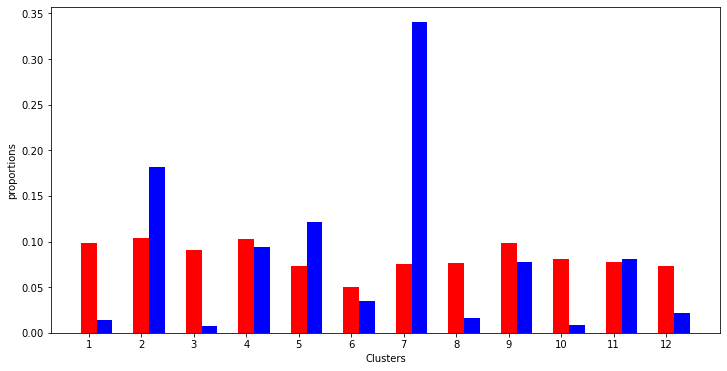

In [200]:
import matplotlib.pyplot as plt
barwidth=0.3
x=np.arange(1,k+1)
plt.figure(figsize=(12,6))

plt.bar(x, gen_labels_f_p[:,2], barwidth,color='r', label='General Population clusters')
plt.bar(x+barwidth ,cust_labels_f_p[:,2], barwidth,color='b', label='Customer clusters')

plt.xlabel('Clusters')
plt.ylabel('proportions')
plt.xticks(x)
plt.legend
plt.show()

In [202]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

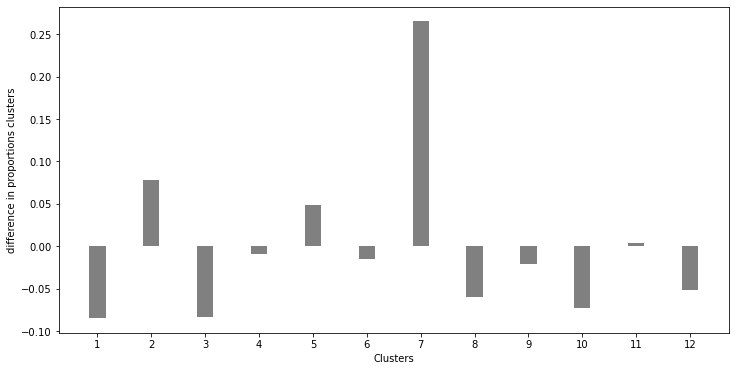

In [203]:
import matplotlib.pyplot as plt
barwidth=0.3
x=np.arange(1,k+1)
plt.figure(figsize=(12,6))

plt.bar(x, cust_labels_f_p[:,2]-gen_labels_f_p[:,2], barwidth,color='grey')

plt.xlabel('Clusters')
plt.ylabel('difference in proportions clusters')
plt.xticks(x)
plt.legend
plt.show()

In [204]:
def map_kmeans_weights_to_feats(kmeans, fd, n):

    weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 4), columns=fd.keys())
    centroid = weights.iloc[n-1]
    centroid = centroid.sort_values(ascending=False)

    return centroid

In [228]:
def plot_cluster(cent,n):
    cent= pd.concat([cent[:5],cent[-5:]])
    bar_width = 0.5
    plt.figure(figsize=(12,6))
    positive=cent>0
    plt.bar(cent.index,cent,bar_width,color=np.vectorize({True: 'k', False: 'r'}.get)(positive))
    plt.title(f'Cluster {n}')
    plt.xticks(cent.index)

    plt.show()


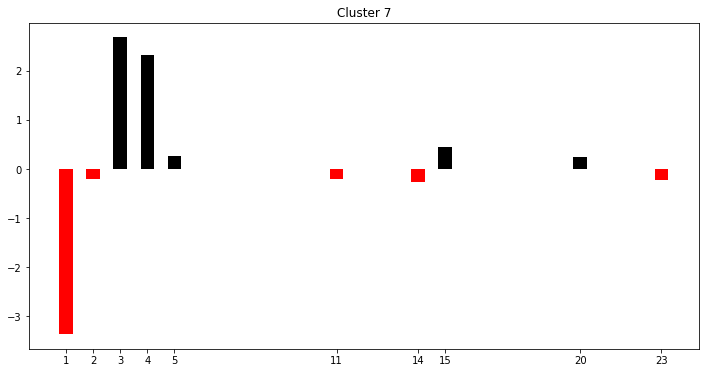

In [230]:
# Overrepresented 
#cluster 7
cent=map_kmeans_weights_to_feats(kmeans, df_cust_pca, 7)
plot_cluster(cent,7)

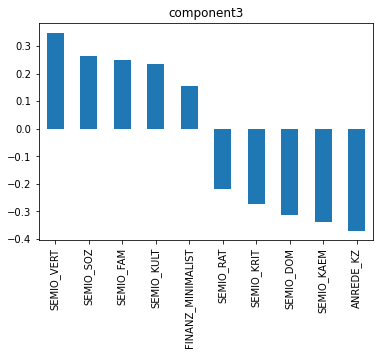

In [232]:
comp=3
component=map_weights_features(pca,fd,comp)
plot_component(component,comp)

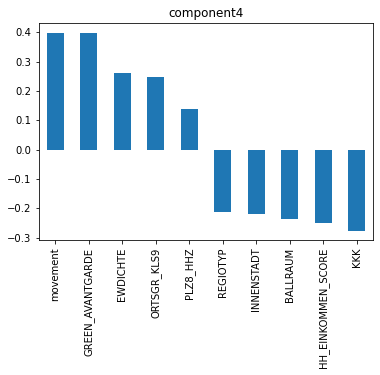

In [233]:
comp=4
component=map_weights_features(pca,fd,comp)
plot_component(component,comp)


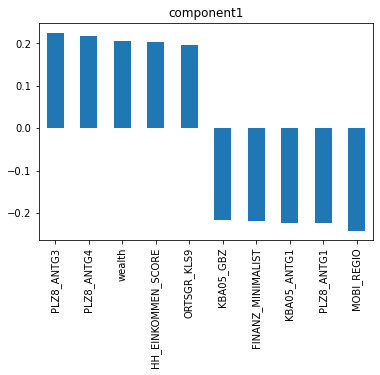

In [238]:
comp=1
component=map_weights_features(pca,fd,comp)
plot_component(component,comp)

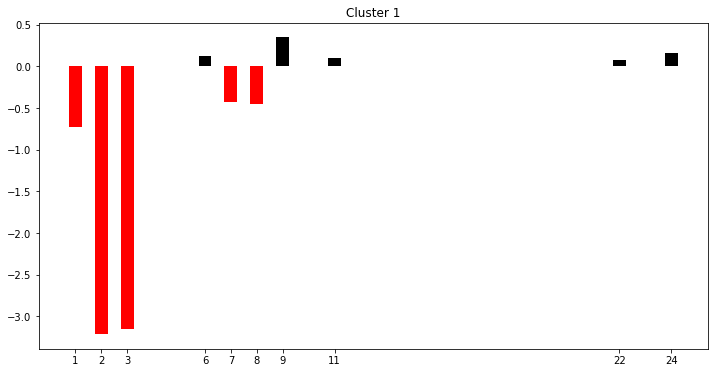

In [240]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# cluster 1 is underrepresented
cent=map_kmeans_weights_to_feats(kmeans, df_cust_pca, 1)
plot_cluster(cent,1)

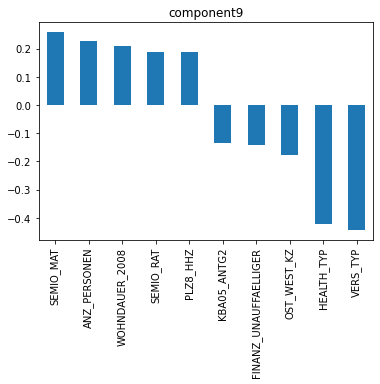

In [243]:
comp=9
component=map_weights_features(pca,fd,comp)
plot_component(component,comp)

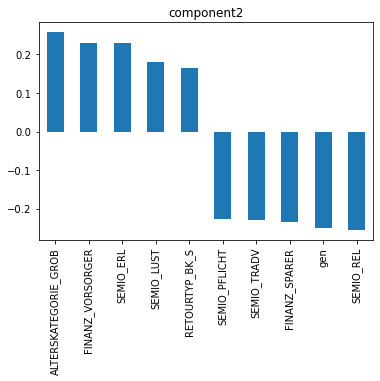

In [244]:
comp=2
component=map_weights_features(pca,fd,comp)
plot_component(component,comp)

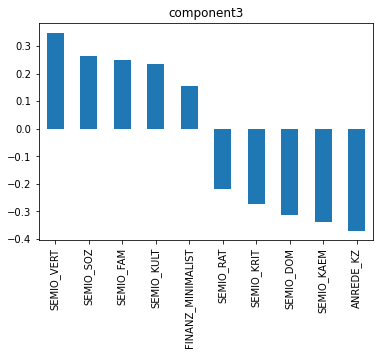

In [245]:
comp=3
component=map_weights_features(pca,fd,comp)
plot_component(component,comp)

### Discussion 3.3: Compare Customer Data to Demographics Data

* we have compared the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population to know which groups of persons are in our interest .
* founding that for customer data:
    cluster 7 is overrepresented and cluster 1 is underrepresented and to find which kind of people is in our overrepresented or underrepresented 
* we have called our pca_plot to get features that each component focus on 
which results in that we would know the kind of people in each cluster


In [246]:
# I have tried to use Silhoutte score but it takes too much time 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.